In [1]:
import pandas as pd
import numpy as np

In [2]:
df = (pd.read_json('data.json', orient = 'index')
        .reset_index()
        .rename(columns = {'index': 'date'})
        .sort_values(by = ['date']))

df.tail()

,date,squat,overhead press,deadlift
50,2022-11-19,NaN,65.0,175.0
47,2022-11-22,150.0,65.0,NaN
51,2022-11-23,NaN,65.0,170.0
48,2022-11-27,145.0,65.0,NaN
52,2022-11-28,NaN,65.0,170.0


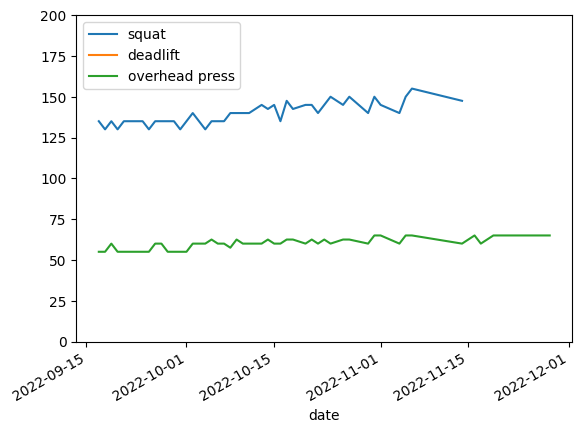

In [3]:
_ = df.plot(x = 'date', y = ['squat', 'deadlift', 'overhead press'], ylim = [0, 200])